In [8]:
from dotenv import load_dotenv
import os
from supabase import create_client, Client
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import spearmanr
from numpy.linalg import norm
from collections import Counter

%matplotlib inline

# Load environment variables
load_dotenv()

# Connect to Supabase
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [9]:
data = supabase.table('user_films_with_films').select('*').execute()
df = pd.DataFrame(data.data)
print(df.head())

    id user_handle                    film_slug              film_title  \
0  705    aaviva_c             lilo-stitch-2025           Lilo & Stitch   
1  706    aaviva_c                     ne-zha-2                Ne Zha 2   
2  707    aaviva_c  a-place-called-silence-2024  A Place Called Silence   
3  708    aaviva_c               look-back-2024               Look Back   
4  709    aaviva_c            inside-out-2-2024            Inside Out 2   

   rating  liked                  created_at  film_year  \
0     3.0  False  2025-07-05T16:48:06.824989       2025   
1     4.0  False  2025-07-05T16:48:06.824989       2025   
2     3.0  False  2025-07-05T16:48:06.824989       2024   
3     4.5  False  2025-07-05T16:48:06.824989       2024   
4     3.5  False  2025-07-05T16:48:06.824989       2024   

          film_directors                                  films_genres  \
0  [Dean Fleischer Camp]  [Adventure, Science Fiction, Comedy, Family]   
1              [Yang Yu]       [Fantasy, Actio

In [10]:
df.describe()

,id,rating,film_year,films_popularity
count,1000.000000,778.000000,1000.000000,1.000000e+03
mean,3491.081000,3.457584,2013.989000,1.622898e+06
std,4662.715994,0.992961,9.077184,1.392130e+06
min,1.000000,0.500000,1942.000000,1.210000e+02
25%,338.750000,3.000000,2010.000000,4.262465e+05
50%,588.500000,3.500000,2017.000000,1.209060e+06
75%,10435.250000,4.000000,2021.000000,2.597253e+06
max,10830.000000,5.000000,2025.000000,5.752396e+06


In [98]:
plt.close('all')

df_aaviva_c = df[df['user_handle'] == 'aaviva_c']
df_guigui08 = df[df['user_handle'] == 'guigui08']
df_kevinchen = df[df['user_handle'] == 'iokkeichen']

In [66]:
def rating_alignment_score(df_a, df_b):

    df_a = df_a.dropna(subset='rating')
    df_b = df_b.dropna(subset='rating')
    
    # Align by common film_slug
    common = set(df_a['film_slug']) & set(df_b['film_slug'])
    if not common:
        return 0.0

    df_a_common = df_a[df_a['film_slug'].isin(common)].copy().sort_values('film_slug')
    df_b_common = df_b[df_b['film_slug'].isin(common)].copy().sort_values('film_slug')

    ratings_a = np.array(df_a_common['rating'])
    ratings_b = np.array(df_b_common['rating'])

    # Agreement rate (within 0.5 stars)
    agreement_rate = np.mean(np.abs(ratings_a - ratings_b) <= 0.5)

    # Mean absolute difference (scaled)
    mad = np.mean(np.abs(ratings_a - ratings_b))
    mad_scaled = 1 - (mad / 3)

    # Spearman correlation (scaled)
    rho, _ = spearmanr(ratings_a, ratings_b)
    rho_scaled = (rho + 1) / 2 if not np.isnan(rho) else 0.5

    # Final weighted score
    score = (
        0.5 * agreement_rate +
        0.3 * mad_scaled +
        0.2 * rho_scaled
    )

    return round(score * 50, 2)  # out of 50

In [82]:
rating_alignment_score(df_guigui08, df_kevinchen), rating_alignment_score(df_aaviva_c, df_kevinchen), rating_alignment_score(df_guigui08, df_aaviva_c)

(33.67, 36.24, 30.28)

In [86]:
def relative_overlap_score(df_a, df_b):
    films_a = set(df_a['film_slug'])
    films_b = set(df_b['film_slug'])

    if not films_a or not films_b:
        return 0.0

    mutual = films_a & films_b
    min_size = min(len(films_a), len(films_b))

    # Avoid div-by-zero, though shouldn't happen
    if min_size == 0:
        return 0.0

    raw_overlap = len(mutual) / min_size
    softened = raw_overlap ** 0.7

    return round(softened * 10, 2)  # out of 10

In [88]:
relative_overlap_score(df_guigui08, df_kevinchen), relative_overlap_score(df_aaviva_c, df_kevinchen), relative_overlap_score(df_guigui08, df_aaviva_c)

(7.04, 4.5, 4.89)

In [16]:
def thematic_overlap_score(df_a, df_b):
    # Flatten and clean genre lists
    genres_a = set(genre for sublist in df_a['films_genres'] for genre in sublist)
    genres_b = set(genre for sublist in df_b['films_genres'] for genre in sublist)

    if not genres_a or not genres_b:
        return 0.0

    mutual = genres_a & genres_b
    total = genres_a | genres_b

    overlap_ratio = len(mutual) / len(total)
    return round(overlap_ratio * 10, 2)  # out of 10

In [90]:
thematic_overlap_score(df_guigui08, df_kevinchen), thematic_overlap_score(df_aaviva_c, df_kevinchen), thematic_overlap_score(df_guigui08, df_aaviva_c)

(9.44, 9.41, 8.89)

In [18]:
def plot_obscurity_histograms(df_a, df_b, popularity_col='films_popularity', bins=10):
    # Log-transform for binning
    log_pop_a = np.log1p(df_a[popularity_col].values)
    log_pop_b = np.log1p(df_b[popularity_col].values)

    # Shared bin edges in log space
    all_log_pop = np.concatenate([log_pop_a, log_pop_b])
    bin_edges_log = np.histogram_bin_edges(all_log_pop, bins=bins)

    # Histogram counts (normalized to %)
    hist_a, _ = np.histogram(log_pop_a, bins=bin_edges_log)
    hist_b, _ = np.histogram(log_pop_b, bins=bin_edges_log)
    hist_a = hist_a / hist_a.sum() * 100
    hist_b = hist_b / hist_b.sum() * 100

    # Plot directly in log space
    plt.figure(figsize=(8, 5))
    width = (bin_edges_log[1] - bin_edges_log[0]) * 0.4
    plt.bar(bin_edges_log[:-1], hist_a, width=width, align='edge', alpha=0.7, label='User A')
    plt.bar(bin_edges_log[:-1] + width, hist_b, width=width, align='edge', alpha=0.7, label='User B')

    # Set ticks exactly at bin edges
    tick_positions = bin_edges_log
    tick_labels = [f"{int(np.expm1(tick)):,}" for tick in tick_positions]
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

    plt.xlabel('Letterboxd Watch Count (Popularity)')
    plt.ylabel('Percentage of Films')
    plt.title('Obscurity Profile Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

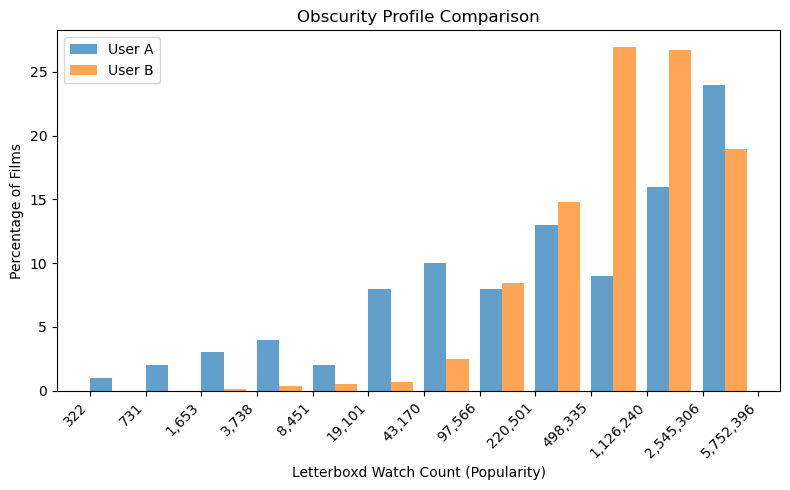

In [19]:
plot_obscurity_histograms(df_aaviva_c, df_guigui08, popularity_col='films_popularity', bins=12)

In [20]:
def obscurity_alignment_score(df_a, df_b, popularity_col='films_popularity', bins=12):
    # Log-transform popularity for binning
    log_pop_a = np.log1p(df_a[popularity_col].values)
    log_pop_b = np.log1p(df_b[popularity_col].values)

    # Shared bin edges across both users (in log space)
    all_log_pop = np.concatenate([log_pop_a, log_pop_b])
    bin_edges_log = np.histogram_bin_edges(all_log_pop, bins=bins)

    # Histograms: counts per bin
    hist_a, _ = np.histogram(log_pop_a, bins=bin_edges_log)
    hist_b, _ = np.histogram(log_pop_b, bins=bin_edges_log)

    # Convert counts to percentages
    hist_a = hist_a / hist_a.sum() * 100 if hist_a.sum() > 0 else hist_a
    hist_b = hist_b / hist_b.sum() * 100 if hist_b.sum() > 0 else hist_b

    # If either has no films, return 0
    if hist_a.sum() == 0 or hist_b.sum() == 0:
        return 0.0

    # Manhattan distance (L1)
    # Max possible distance is 200 (100% vs 0% in each bin)
    manhattan_distance = np.sum(np.abs(hist_a - hist_b))
    score = (1 - (manhattan_distance / 200)) * 10  # scale to 0–10

    return round(score, 2)

In [92]:
obscurity_alignment_score(df_guigui08, df_kevinchen), obscurity_alignment_score(df_aaviva_c, df_kevinchen), obscurity_alignment_score(df_guigui08, df_aaviva_c)

(7.67, 7.85, 6.91)

In [42]:
def director_overlap_score(df_a, df_b, director_col='film_directors', power=0.5, min_count=3):
    def get_director_counts(df):
        counter = Counter()
        for d in df[director_col]:
            if isinstance(d, list):
                directors = [name.strip() for name in d]
            elif isinstance(d, str):
                directors = [name.strip() for name in d.split(',')]
            else:
                continue
            counter.update(directors)
        return counter

    # Count how many times each director appears
    counts_a = get_director_counts(df_a)
    counts_b = get_director_counts(df_b)

    # Only include directors with at least `min_count` films logged
    directors_a = {d for d, count in counts_a.items() if count >= min_count}
    directors_b = {d for d, count in counts_b.items() if count >= min_count}

    if not directors_a or not directors_b:
        return 0.0

    mutual = directors_a & directors_b

    # Coverage per user
    coverage_a = len(mutual) / len(directors_a)
    coverage_b = len(mutual) / len(directors_b)

    avg_coverage = (coverage_a + coverage_b) / 2
    softened = math.pow(avg_coverage, power)

    return round(softened * 10, 2)

In [94]:
director_overlap_score(df_guigui08, df_kevinchen), director_overlap_score(df_aaviva_c, df_kevinchen), director_overlap_score(df_guigui08, df_aaviva_c)

(6.1, 7.75, 5.91)

In [46]:
def diversity_bonus(df_a, df_b, genres_col='films_genres', max_genres=20):
    # 1. Identify mutual films
    mutual_slugs = set(df_a['film_slug']) & set(df_b['film_slug'])

    if not mutual_slugs:
        return 0.0

    # 2. Subset both to mutual films
    df_a_mutual = df_a[df_a['film_slug'].isin(mutual_slugs)]
    df_b_mutual = df_b[df_b['film_slug'].isin(mutual_slugs)]

    # 3. Combine genre sets from both users' records of mutual films
    genres = set()
    for genres_list in list(df_a_mutual[genres_col]) + list(df_b_mutual[genres_col]):
        if isinstance(genres_list, list):
            genres.update([g.strip() for g in genres_list])
        elif isinstance(genres_list, str):
            genres.update([g.strip() for g in genres_list.split(',')])

    # 4. Normalize: more genres → higher diversity
    diversity_ratio = min(len(genres), max_genres) / max_genres
    return round(diversity_ratio * 10, 2)

In [96]:
diversity_bonus(df_guigui08, df_kevinchen), diversity_bonus(df_aaviva_c, df_kevinchen), diversity_bonus(df_guigui08, df_aaviva_c)

(8.0, 8.0, 8.0)

In [50]:
def cineblend_score(df_a, df_b):
    # Each function already returns a value between 0 and its weighted share of 100
    rating = rating_alignment_score(df_a, df_b)
    overlap = relative_overlap_score(df_a, df_b)
    theme = thematic_overlap_score(df_a, df_b)
    obscurity = obscurity_alignment_score(df_a, df_b)
    directors = director_overlap_score(df_a, df_b)
    diversity = diversity_bonus(df_a, df_b)

    # Convert any sets to floats before adding
    # This is the likely source of the error
    rating = float(rating) if isinstance(rating, set) else rating
    overlap = float(overlap) if isinstance(overlap, set) else overlap
    theme = float(theme) if isinstance(theme, set) else theme
    obscurity = float(obscurity) if isinstance(obscurity, set) else obscurity
    directors = float(directors) if isinstance(directors, set) else directors
    diversity = float(diversity) if isinstance(diversity, set) else diversity

    total_score = rating + overlap + theme + obscurity + directors + diversity
    return round(total_score, 2)

In [102]:
print("CineBlend Score for aaviva_c and guigui08:", cineblend_score(df_aaviva_c, df_guigui08)) 

CineBlend Score for aaviva_c and guigui08: 64.88


In [104]:
print("CineBlend Score for aaviva_c and iokkeichen:", cineblend_score(df_aaviva_c, df_kevinchen)) 

CineBlend Score for aaviva_c and iokkeichen: 73.75


In [106]:
print("CineBlend Score for guigui08 and iokkeichen:", cineblend_score(df_guigui08, df_kevinchen)) 

CineBlend Score for guigui08 and iokkeichen: 71.92
